# A closer look at the covid-related behaviors in Yolo County and other counties in CA 

In this notebook, we specifically look at various questions that may reflect personal covid-19 pre-cautions in various counties in California.

In [1]:
import numpy as np
import pandas as pd
import os
import re
import datetime as dt
import matplotlib.pyplot as plt
import plotnine as p9
# Load all the locally installed packages
%cd /export/home/honlee/local/lib64/python3.6/site-packages
import sqlalchemy as sqla
import pymongo
%cd ../../../../
from loadEngine import *
from utilities import *
%matplotlib inline

/export/home/honlee/local/lib64/python3.6/site-packages
/export/home/honlee


In [2]:
# Check if a file exists, it so, we load it directly
# if not, we will make an engine for querying the data
engine = loadEngine("data/survey.sqlite")

In [15]:
# Show all tables stored in the database
insp = sqla.inspect(engine)
print(insp.get_table_names())

['area', 'job', 'survey', 'zipcodes']


In [3]:
# Since the zipcodes in the survey have not been cleaned, we will merge the table after we clean the zipcodes.
query = """
    SELECT zip, county from
    zipcodes
"""
zipcodes = pd.read_sql_query(query, engine)
zipcodes["zip"] = zipcodes["zip"].astype("str")

## Method

We will aggregate the data to county-level based on zipcodes provided by a csv file under zip code database website free version (https://www.unitedstateszipcodes.org/zip-code-database/). We have stored this as a table named `zipcodes` in the `survey.sqlite` file. For each county, we then show the response rates for each of the questions listed below and hope to capture any trends that may show consistently. Finally, we will compare them with the response rates from Yolo County.

To evaluate the public behaviour, we have selected the following questions from the survey:

* **Travel tendency**: Have you travelled outside of your state? (C6) wave 1

* **Purposes of the travel**: In the last 24 hours, have you done any of the following? Please select all that apply (C13) wave 4

* **Social distancing**: To what extent are you intentionally avoiding contact with other people? (C7) wave 1

* **Social distancing**: In the past 24 hours, have you had direct contact with anyone who recently tested positive for COVID-19 (coronavirus)?"Direct contact" means: a conversation lasting more than 5 minutes with a person who is closer than 6 feet away from you or physical contact like handshaking, hugging, or kissing. (C11)

* **Mask wearing**: In the past 5 days, how often did you wear a mask when in public? (C14) wave 4

* **Mask wearing**: During which activities in the past 24 hours did you wear a mask? Please select all that apply.(C13a)

* **Vaccination coverage**: Have you had a COVID-19 (coronavirus) vaccination? (V1)

* **Vaccination hesitancy**: If a vaccine to prevent COVID-19 (coronavirus) were offered to you today, would you choose to get vaccinated? (V3)



## Question C6

Have you travelled outside of your state?

In [50]:
# Get the total response number for C6
query = """
    SELECT EndDatetime as Date, A3 as zipcode, COUNT(*) as total_response_for_C6
    FROM survey
    WHERE A3 >= 90001 AND A3 < 96163 AND (C6 IS NOT NULL OR C6 != "NaN")
    GROUP BY EndDatetime, A3
"""
C6_total_response = pd.read_sql_query(query, engine)
C6_total_response_cleaned = addCounty(C6_total_response, zipcodes)
# Show the first five rows
C6_total_response_cleaned.head()

,Date,zipcode,total_response_for_C6,zip,county
0,2020-04-06,90002,2,90002,Los Angeles County
1,2020-04-06,90003,4,90003,Los Angeles County
2,2020-04-06,90004,8,90004,Los Angeles County
3,2020-04-06,90006,1,90006,Los Angeles County
4,2020-04-06,90008,3,90008,Los Angeles County


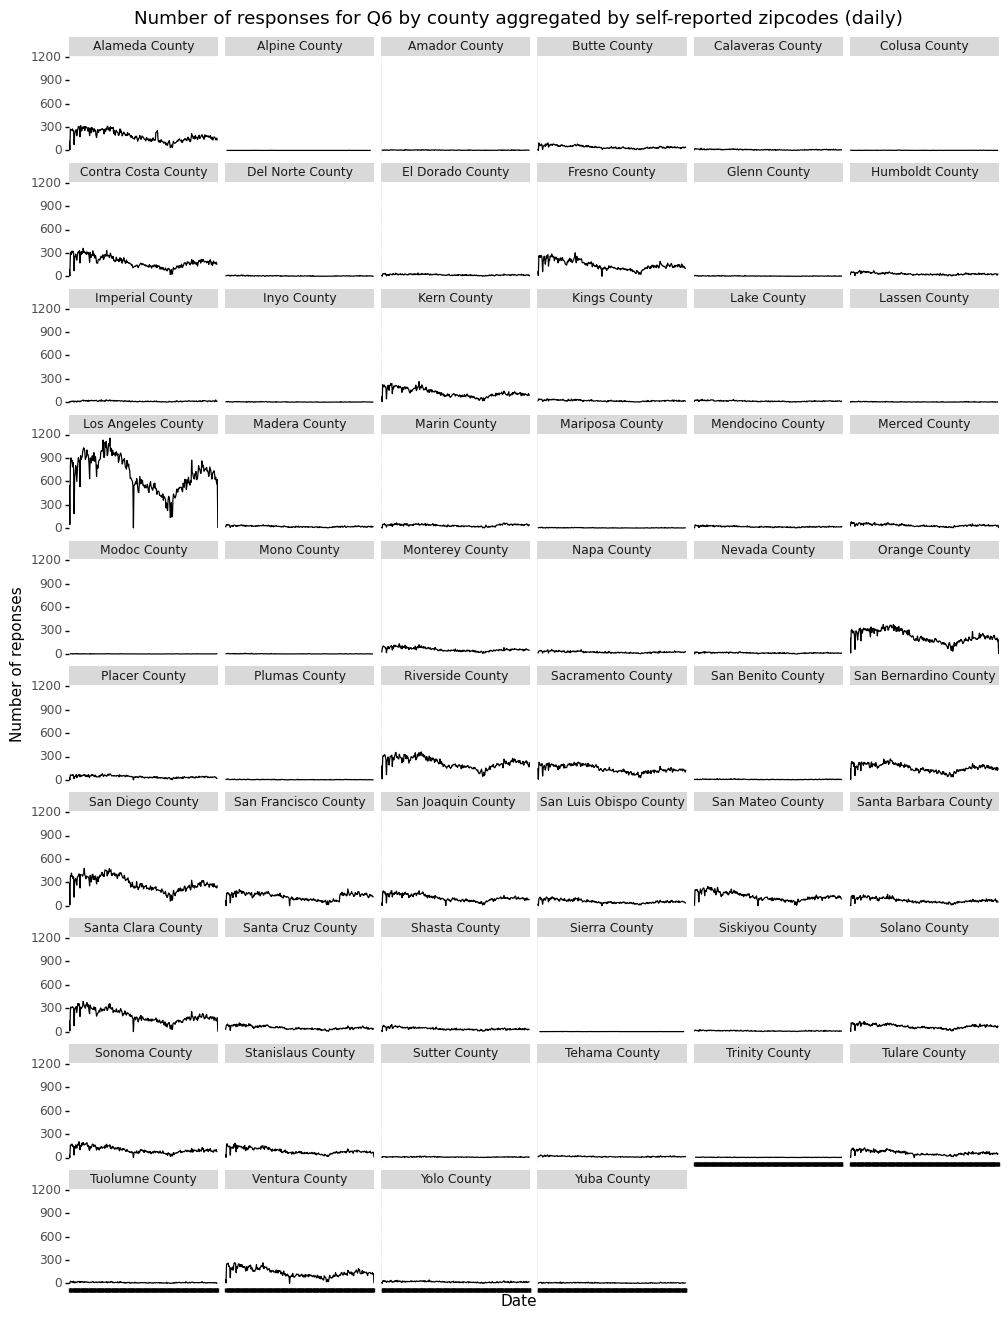

<ggplot: (8773502074074)>

In [51]:
# Aggregate the number of total response by county and date
df = C6_total_response_cleaned.groupby(["Date", "county"]).sum().reset_index()
(
    p9.ggplot(df, p9.aes(x='Date', y='total_response_for_C6', group = 1))
    + p9.geom_line() # line plot
    + p9.labs(x='Date', y='Number of reponses', title="Number of responses for C6 by county aggregated by self-reported zipcodes (daily)")
    + p9.theme(figure_size=(12, 16), axis_text_x=p9.element_blank())
    + p9.facet_wrap('county', nrow=10)
)

### The above shows the number of responses may be too low for some counties, let's aggregate the number of responses by month

We see that the more populous the county is, the more responses we tend to get. For example, Los Anageles county has a good number of responses in comparison with others. We also notice that the number of responses drop consistently across counties around November. 

In [52]:
# Aggregate the data to a monthly level
C6_total_response_cleaned["Date by month"] = ["-".join(i.split("-")[0:2]) for i in C6_total_response_cleaned["Date"]]
C6_monthly_total_response = C6_total_response_cleaned.groupby(["Date by month", "county"]).sum()
C6_monthly_total_response = C6_monthly_total_response.reset_index()
C6_monthly_total_response.head()

,Date by month,county,total_response_for_C6
0,2020-04,Alameda County,133
1,2020-04,Amador County,5
2,2020-04,Butte County,20
3,2020-04,Calaveras County,5
4,2020-04,Colusa County,3


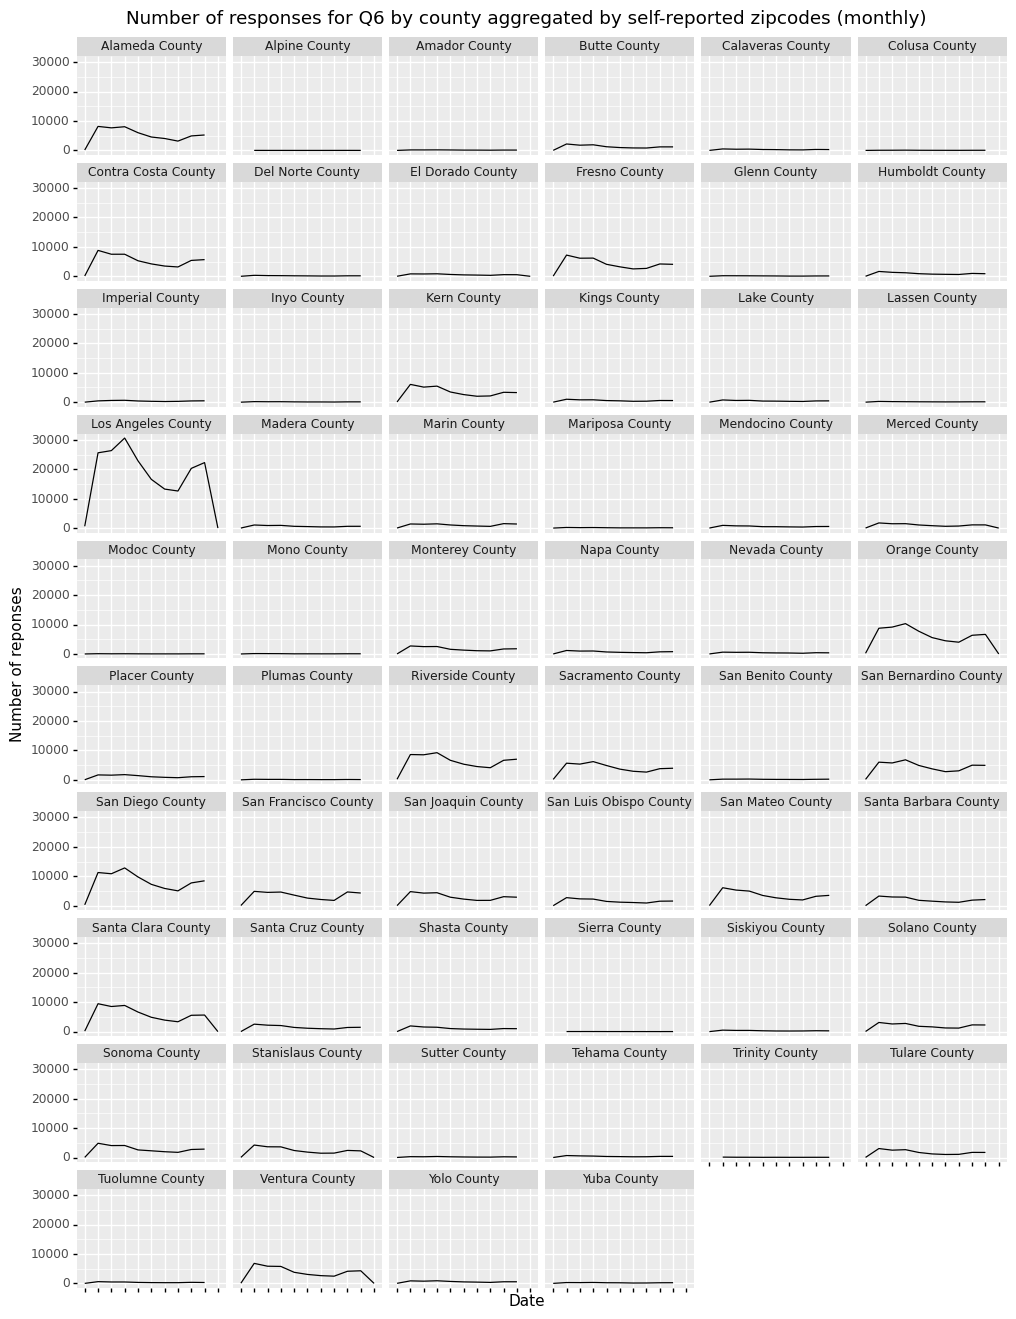

<ggplot: (8773494490025)>

In [53]:
# Aggregate the number of total response by county and date
(
    p9.ggplot(C6_monthly_total_response, p9.aes(x='Date by month', y='total_response_for_C6', group = 1))
    + p9.geom_line() # line plot
    + p9.labs(x='Date', y='Number of reponses', title="Number of responses for C6 by county aggregated by self-reported zipcodes (monthly)")
    + p9.theme(figure_size=(12, 16), axis_text_x=p9.element_blank())
    + p9.facet_wrap('county', nrow=10)
)

### Zoom into Yolo county 

Plotting all the counties may not reflect the actual trends in the counties that have lower number of responses, let's look at Yolo County responses to question C6

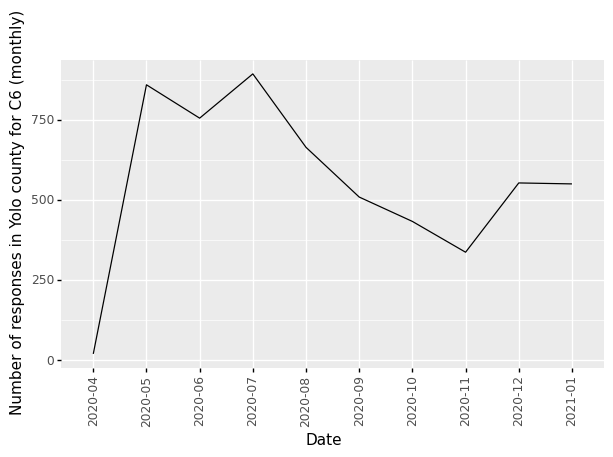

<ggplot: (-9223363263365223992)>

In [60]:
(
    p9.ggplot(C6_monthly_total_response[C6_monthly_total_response["county"] == "Yolo County"], p9.aes(x='Date by month', y='total_response_for_C6', group = 1))
    + p9.geom_line() # line plot
    + p9.labs(x='Date', y='Number of responses in Yolo county for C6 (monthly)')
    + p9.theme(figure_size=(7, 4), axis_text_x=p9.element_text(rotation=90))
)

### Now, let's look at the percentage of respondants that said yes to question C6

In [71]:
# Get the total response number for C6
query = """
    SELECT EndDatetime as Date, A3 as zipcode, COUNT(*) as yes_response_for_C6
    FROM survey
    WHERE A3 >= 90001 AND A3 < 96163 AND C6 = 1.0
    GROUP BY EndDatetime, A3
"""
c6_yes = pd.read_sql_query(query, engine)
c6_yes_cleaned = addCounty(c6_yes, zipcodes)
# Show the first five rows
c6_yes_cleaned.head()

,Date,zipcode,yes_response_for_C6,zip,county
0,2020-04-06,90049,1,90049,Los Angeles County
1,2020-04-06,90060,1,90060,Los Angeles County
2,2020-04-06,90210,1,90210,Los Angeles County
3,2020-04-06,90291,1,90291,Los Angeles County
4,2020-04-06,90719,1,90719,Los Angeles County


In [73]:
# Aggregate the data to monthly level
c6_yes_cleaned["Date by month"] = ["-".join(i.split("-")[0:2]) for i in c6_yes_cleaned["Date"]]
C6_monthly_yes_response = c6_yes_cleaned.groupby(["Date by month", "county"]).sum()
C6_monthly_yes_response= C6_monthly_yes_response.reset_index()

In [77]:
# merge two dataframes to compute the percentage of yes 
merged_df = pd.merge(C6_monthly_yes_response, C6_monthly_total_response, on=["Date by month", "county"])
merged_df["yes_percentage"] = merged_df["yes_response_for_C6"]/merged_df["total_response_for_C6"] * 100
merged_df

,Date by month,county,yes_response_for_C6,total_response_for_C6,yes_percentage
0,2020-04,Contra Costa County,1,102,0.980392
1,2020-04,Del Norte County,1,4,25.000000
2,2020-04,El Dorado County,1,20,5.000000
3,2020-04,Imperial County,1,11,9.090909
4,2020-04,Kern County,2,84,2.380952
...,...,...,...,...,...
536,2021-01,Tulare County,38,1723,2.205456
537,2021-01,Tuolumne County,5,302,1.655629
538,2021-01,Ventura County,84,4286,1.959869
539,2021-01,Yolo County,8,550,1.454545


### Let's look at the percentage over time for each county

It seems like Alpine county has some strong changes in percentages, let's look at more closely by showing up the table below to see what is going with Apline county.

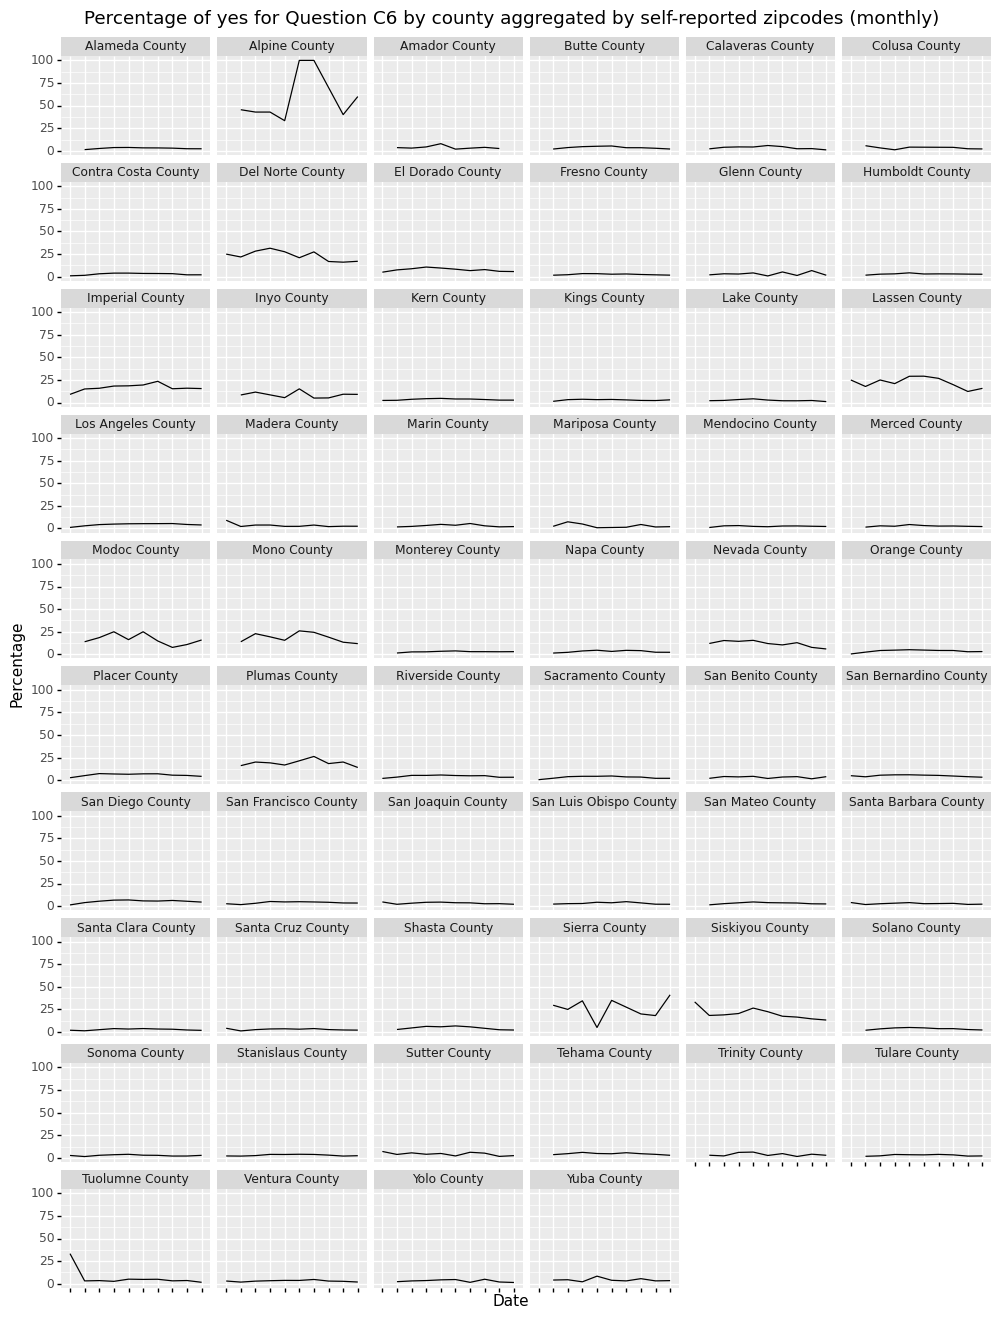

<ggplot: (8773488265238)>

In [78]:
# Aggregate the number of total response by county and date
(
    p9.ggplot(merged_df, p9.aes(x='Date by month', y='yes_percentage', group = 1))
    + p9.geom_line() # line plot
    + p9.labs(x='Date', y='Percentage', title="Percentage of yes for Question C6 by county aggregated by self-reported zipcodes (monthly)")
    + p9.theme(figure_size=(12, 16), axis_text_x=p9.element_blank())
    + p9.facet_wrap('county', nrow=10)
)

### We see that Alpine county doesn't have a lot of responses for this question C6.

In [82]:
merged_df[merged_df["county"] == "Alpine County"]

,Date by month,county,yes_response_for_C6,total_response_for_C6,yes_percentage
26,2020-05,Alpine County,5,11,45.454545
84,2020-06,Alpine County,3,7,42.857143
142,2020-07,Alpine County,3,7,42.857143
200,2020-08,Alpine County,1,3,33.333333
258,2020-09,Alpine County,3,3,100.000000
314,2020-10,Alpine County,2,2,100.000000
427,2020-12,Alpine County,4,10,40.000000
485,2021-01,Alpine County,3,5,60.000000


### Let's compare Yolo county with other counties

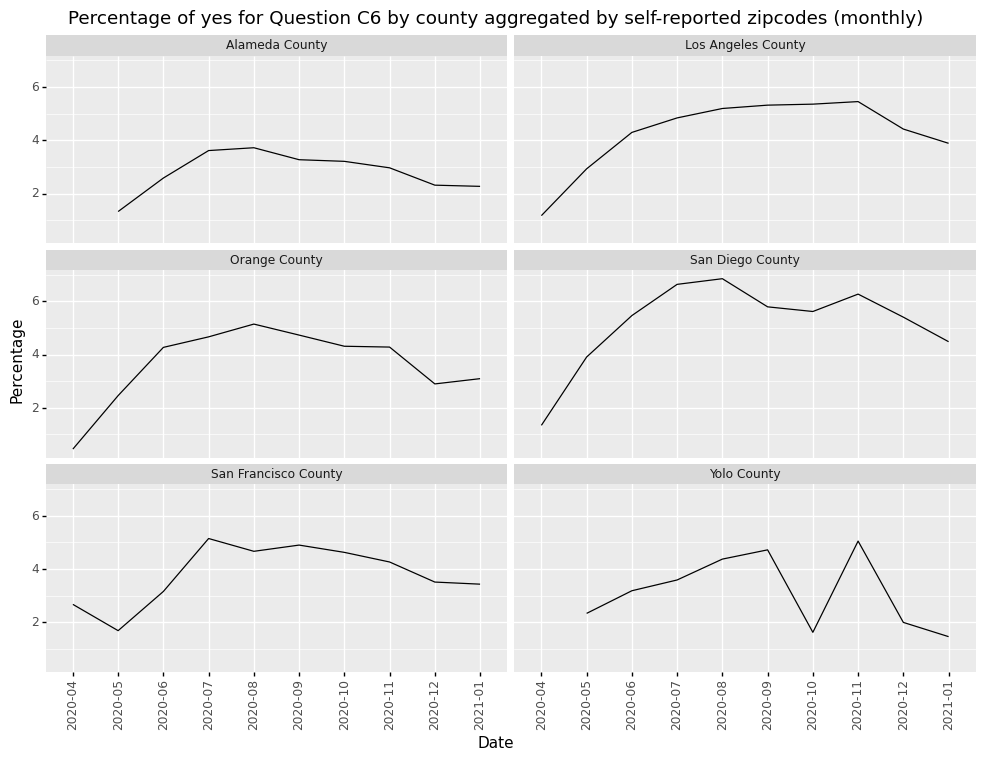

<ggplot: (-9223363263232374542)>

In [93]:
# Aggregate the number of total response by county and date
df = merged_df[merged_df["county"].isin(["Yolo County", "San Diego County", "San Francisco County", "Alameda County","Orange County", "Los Angeles County"])]
(
    p9.ggplot(df, p9.aes(x='Date by month', y='yes_percentage', group = 1))
    + p9.geom_line() # line plot
    + p9.labs(x='Date', y='Percentage', title="Percentage of yes for Question C6 by county aggregated by self-reported zipcodes (monthly)")
    + p9.theme(figure_size=(12, 8), axis_text_x=p9.element_text(rotation=90))
    + p9.facet_wrap('county', nrow=3)
)

### Now, we want to look at some activities people did in 24 hours before they answered the survey

## Question C13

In [4]:
# Get the total response number for C13
query = """
    SELECT EndDatetime as Date, A3 as zipcode, COUNT(*) as total_response_for_C13
    FROM survey
    WHERE A3 >= 90001 AND A3 < 96163 AND (C13 IS NOT NULL OR C13 != "NaN")
    GROUP BY EndDatetime, A3
"""
c13_total_response = pd.read_sql_query(query, engine)
c13_total_response_cleaned = addCounty(c13_total_response, zipcodes)
# Show the first five rows
c13_total_response_cleaned.head()

,Date,zipcode,total_response_for_C13,zip,county
0,2020-09-08,90001,3,90001,Los Angeles County
1,2020-09-08,90002,3,90002,Los Angeles County
2,2020-09-08,90003,5,90003,Los Angeles County
3,2020-09-08,90004,2,90004,Los Angeles County
4,2020-09-08,90005,3,90005,Los Angeles County


In [5]:
c13_total_response_cleaned["Date by month"] = ["-".join(i.split("-")[0:2]) for i in c13_total_response_cleaned["Date"]]
c13_monthly_total_response = c13_total_response_cleaned.groupby(["Date by month", "county"]).sum()
c13_monthly_total_response= c13_monthly_total_response.reset_index()
c13_monthly_total_response

,Date by month,county,total_response_for_C13
0,2020-09,Alameda County,3544
1,2020-09,Alpine County,2
2,2020-09,Amador County,80
3,2020-09,Butte County,779
4,2020-09,Calaveras County,211
...,...,...,...
291,2021-02,Merced County,1
292,2021-02,Orange County,1
293,2021-02,Santa Clara County,1
294,2021-02,Stanislaus County,1


In [6]:
query = """
    SELECT EndDatetime as Date, A3 as zipcode, C13
    FROM survey
    WHERE A3 >= 90001 AND A3 < 96163 AND (C13 IS NOT NULL OR C13 != "NaN")
"""
view = pd.read_sql_query(query, engine)
view.head()

,Date,zipcode,C13
0,2020-09-08,95391,"2,4,5"
1,2020-09-08,94040,"1,2"
2,2020-09-08,95603,"1,2"
3,2020-09-08,92606,"2,4"
4,2020-09-08,95608,8


In [7]:
# Stack the dataframe by the response choices
splitted = view["C13"].str.split(',',expand=True)
view[splitted.columns] = splitted
ls_df = list()
for i in range(len(splitted.columns)):
    dummy = view[["Date","zipcode",i]]
    dummy.columns = ["Date","zipcode", 0]
    ls_df.append(dummy.reset_index())
stacked_view = pd.concat(ls_df)
# Drop all the rows that contain missing values for the result
stacked_view.dropna(subset=[0], inplace=True)
stacked_view = stacked_view[["Date", "zipcode", 0]]
# rename columns
stacked_view.columns = ["Date", "zipcode", "C13"]
# Clean up the zip code
cleaned_stacked_view = addCounty(stacked_view, zipcodes)
# Aggregate by month
cleaned_stacked_view["Date by month"] = ["-".join(i.split("-")[0:2]) for i in cleaned_stacked_view["Date"]]
cleaned_stacked_view_month = cleaned_stacked_view.loc[:,["Date by month", "county", "C13"]] # filter the data
cleaned_stacked_view_month["count"] = 1 # add a column for groupby sum
# compute the aggregated number of responses for each choice
c13_response = cleaned_stacked_view_month.groupby(["Date by month", "county","C13"]).sum().reset_index() # group by county and response


### C13: Gone to work or school outside the place where you are currently staying

In [10]:
c13_response_1 = c13_response[c13_response["C13"]=="1"]
# merget two dataframe
merged_c13_df_1 = pd.merge(c13_response_1, c13_monthly_total_response, on = ["Date by month", "county"])
merged_c13_df_1["Percentage"]= merged_c13_df_1["count"]/merged_c13_df_1["total_response_for_C13"] * 100
merged_c13_df_1

,Date by month,county,C13,count,total_response_for_C13,Percentage
0,2020-09,Alameda County,1,873,3544,24.633183
1,2020-09,Amador County,1,22,80,27.500000
2,2020-09,Butte County,1,248,779,31.835687
3,2020-09,Calaveras County,1,62,211,29.383886
4,2020-09,Colusa County,1,14,34,41.176471
...,...,...,...,...,...,...
285,2021-01,Ventura County,1,1116,4494,24.833111
286,2021-01,Yolo County,1,147,576,25.520833
287,2021-01,Yuba County,1,63,247,25.506073
288,2021-02,Los Angeles County,1,1,1,100.000000


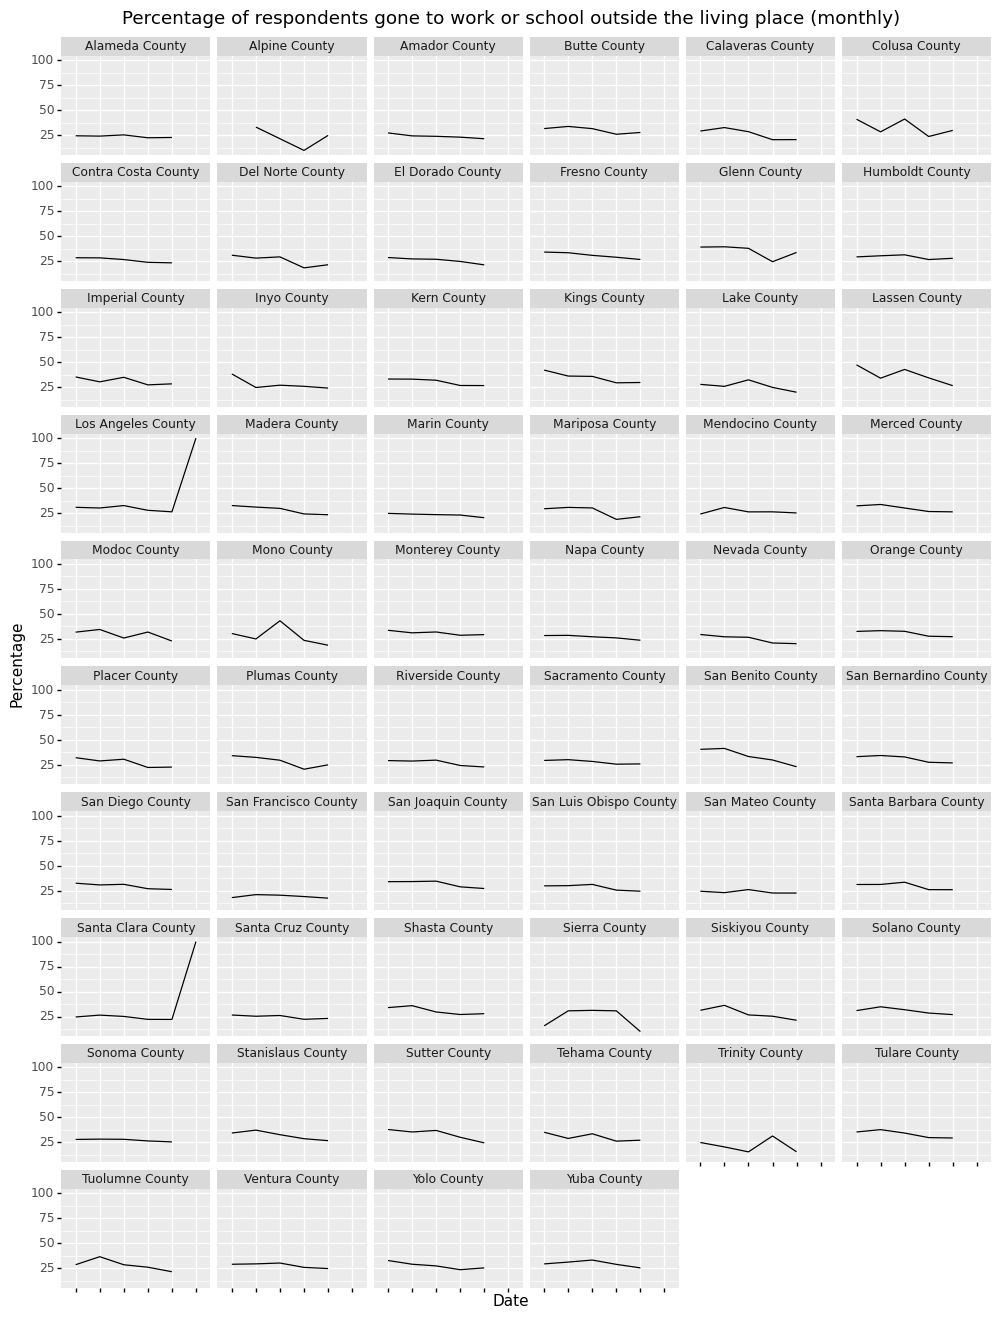

<ggplot: (-9223363279418872085)>

In [13]:
# Aggregate the number of total response by county and date
(
    p9.ggplot(merged_c13_df_1[["Date by month", "county", "Percentage"]], p9.aes(x='Date by month', y='Percentage', group = 1))
    + p9.geom_line() # line plot
    + p9.labs(x='Date', y='Percentage', title="Percentage of respondents gone to work or school outside the living place (monthly)")
    + p9.theme(figure_size=(12, 16), axis_text_x=p9.element_blank())
    + p9.facet_wrap('county', nrow=10)
)

### C13: Gone to a market, grocery store, or pharmacy

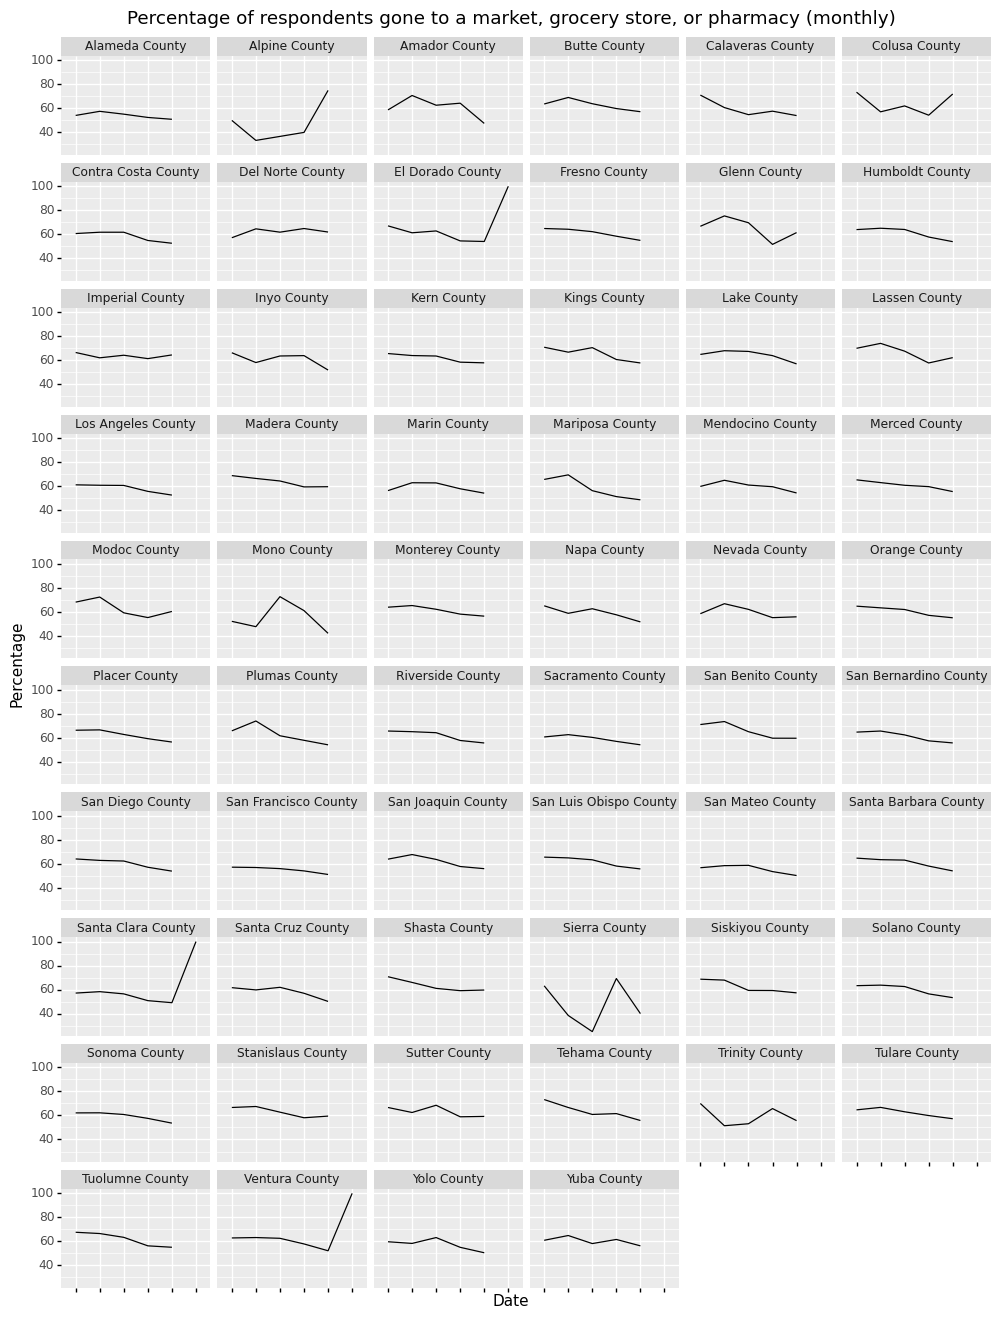

<ggplot: (8757434954886)>

In [14]:
c13_response_2 = c13_response[c13_response["C13"]=="2"]
# merget two dataframe
merged_c13_df_2 = pd.merge(c13_response_2, c13_monthly_total_response, on = ["Date by month", "county"])
merged_c13_df_2["Percentage"]= merged_c13_df_2["count"]/merged_c13_df_2["total_response_for_C13"] * 100
# Aggregate the number of total response by county and date
(
    p9.ggplot(merged_c13_df_2[["Date by month", "county", "Percentage"]], p9.aes(x='Date by month', y='Percentage', group = 1))
    + p9.geom_line() # line plot
    + p9.labs(x='Date', y='Percentage', title="Percentage of respondents gone to a market, grocery store, or pharmacy (monthly)")
    + p9.theme(figure_size=(12, 16), axis_text_x=p9.element_blank())
    + p9.facet_wrap('county', nrow=10)
)

### C13: Gone to a bar, restaurant, or cafe

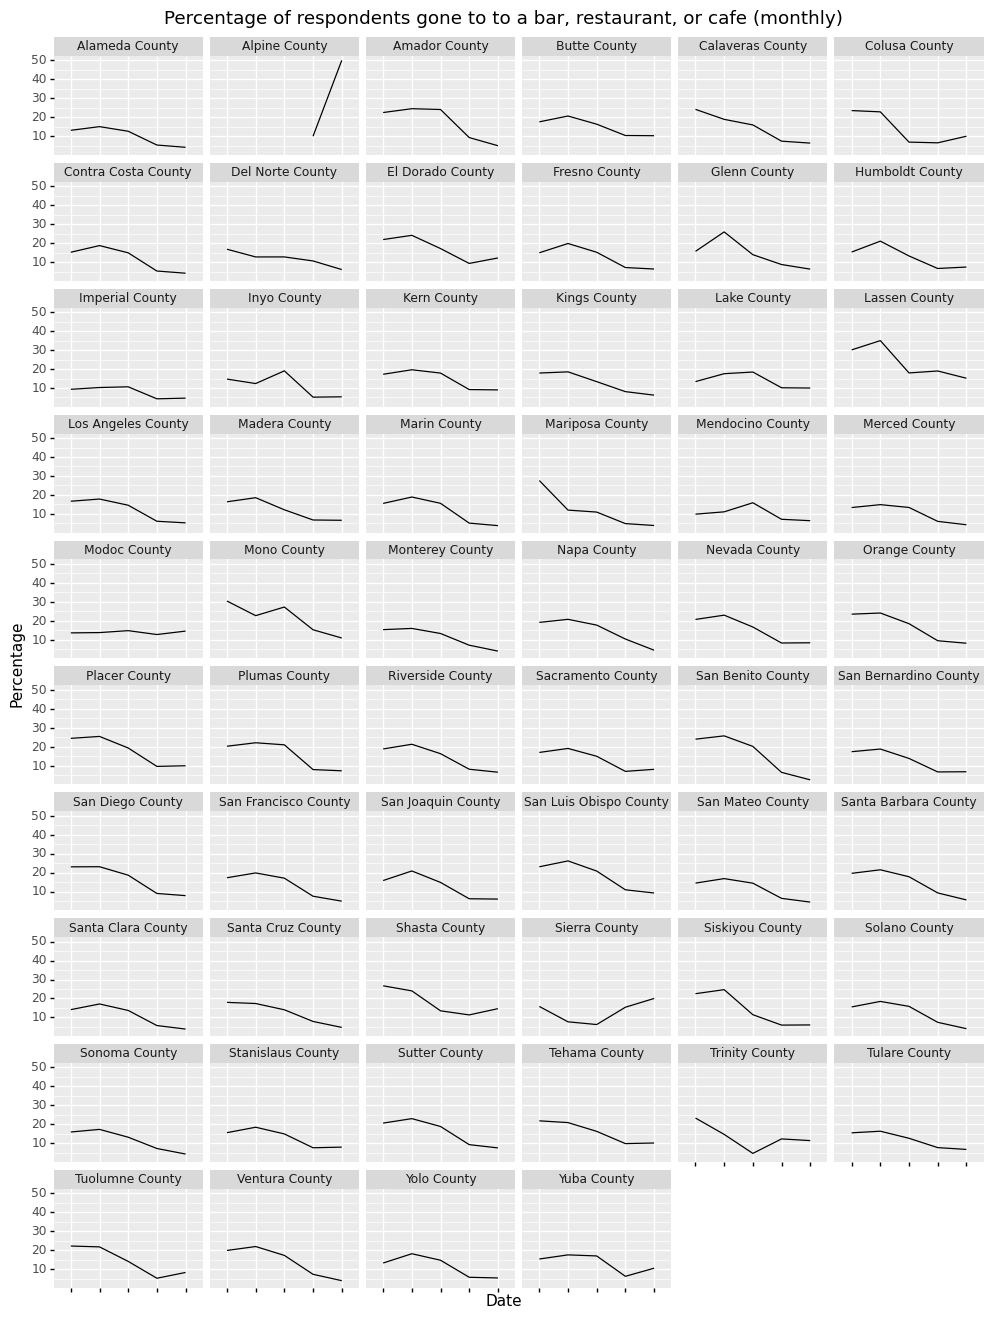

<ggplot: (8757636943915)>

In [15]:
c13_response_3 = c13_response[c13_response["C13"]=="3"]
# merget two dataframe
merged_c13_df_3 = pd.merge(c13_response_3, c13_monthly_total_response, on = ["Date by month", "county"])
merged_c13_df_3["Percentage"]= merged_c13_df_3["count"]/merged_c13_df_3["total_response_for_C13"] * 100
# Aggregate the number of total response by county and date
(
    p9.ggplot(merged_c13_df_3[["Date by month", "county", "Percentage"]], p9.aes(x='Date by month', y='Percentage', group = 1))
    + p9.geom_line() # line plot
    + p9.labs(x='Date', y='Percentage', title="Percentage of respondents gone to to a bar, restaurant, or cafe (monthly)")
    + p9.theme(figure_size=(12, 16), axis_text_x=p9.element_blank())
    + p9.facet_wrap('county', nrow=10)
)

### C13: spent time with someone who isn't currently staying with you

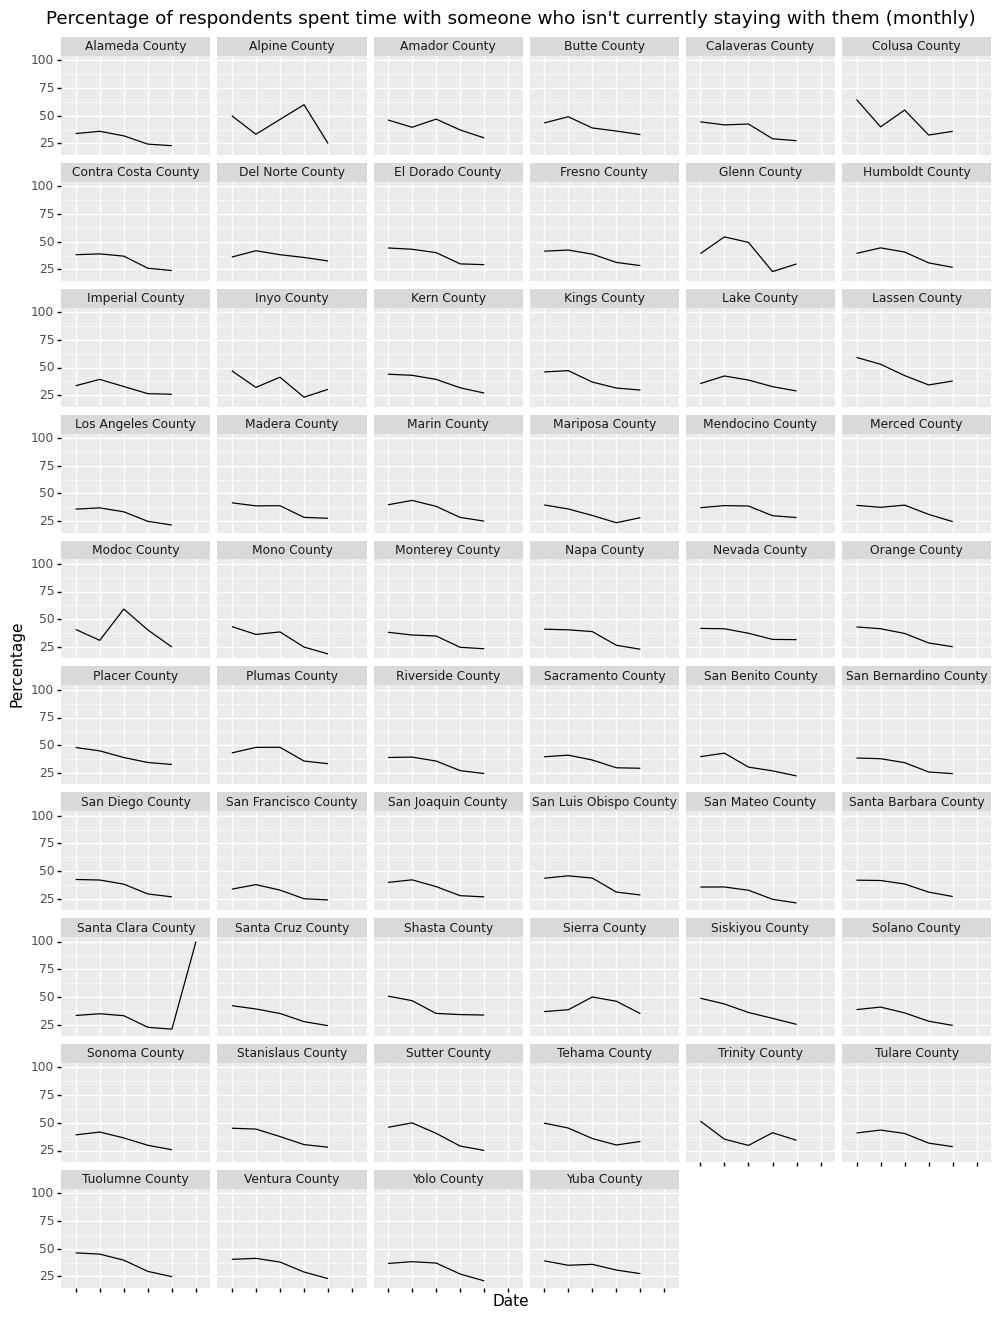

<ggplot: (8757435895700)>

In [16]:
c13_response_4 = c13_response[c13_response["C13"]=="4"]
# merget two dataframe
merged_c13_df_4 = pd.merge(c13_response_4, c13_monthly_total_response, on = ["Date by month", "county"])
merged_c13_df_4["Percentage"]= merged_c13_df_4["count"]/merged_c13_df_4["total_response_for_C13"] * 100
# Aggregate the number of total response by county and date
(
    p9.ggplot(merged_c13_df_4[["Date by month", "county", "Percentage"]], p9.aes(x='Date by month', y='Percentage', group = 1))
    + p9.geom_line() # line plot
    + p9.labs(x='Date', y='Percentage', title="Percentage of respondents spent time with someone who isn't currently staying with them (monthly)")
    + p9.theme(figure_size=(12, 16), axis_text_x=p9.element_blank())
    + p9.facet_wrap('county', nrow=10)
)

### C13: Attended an event with more than 10 people

/usr/local/lib/python3.6/site-packages/plotnine/geoms/geom_path.py:83: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?


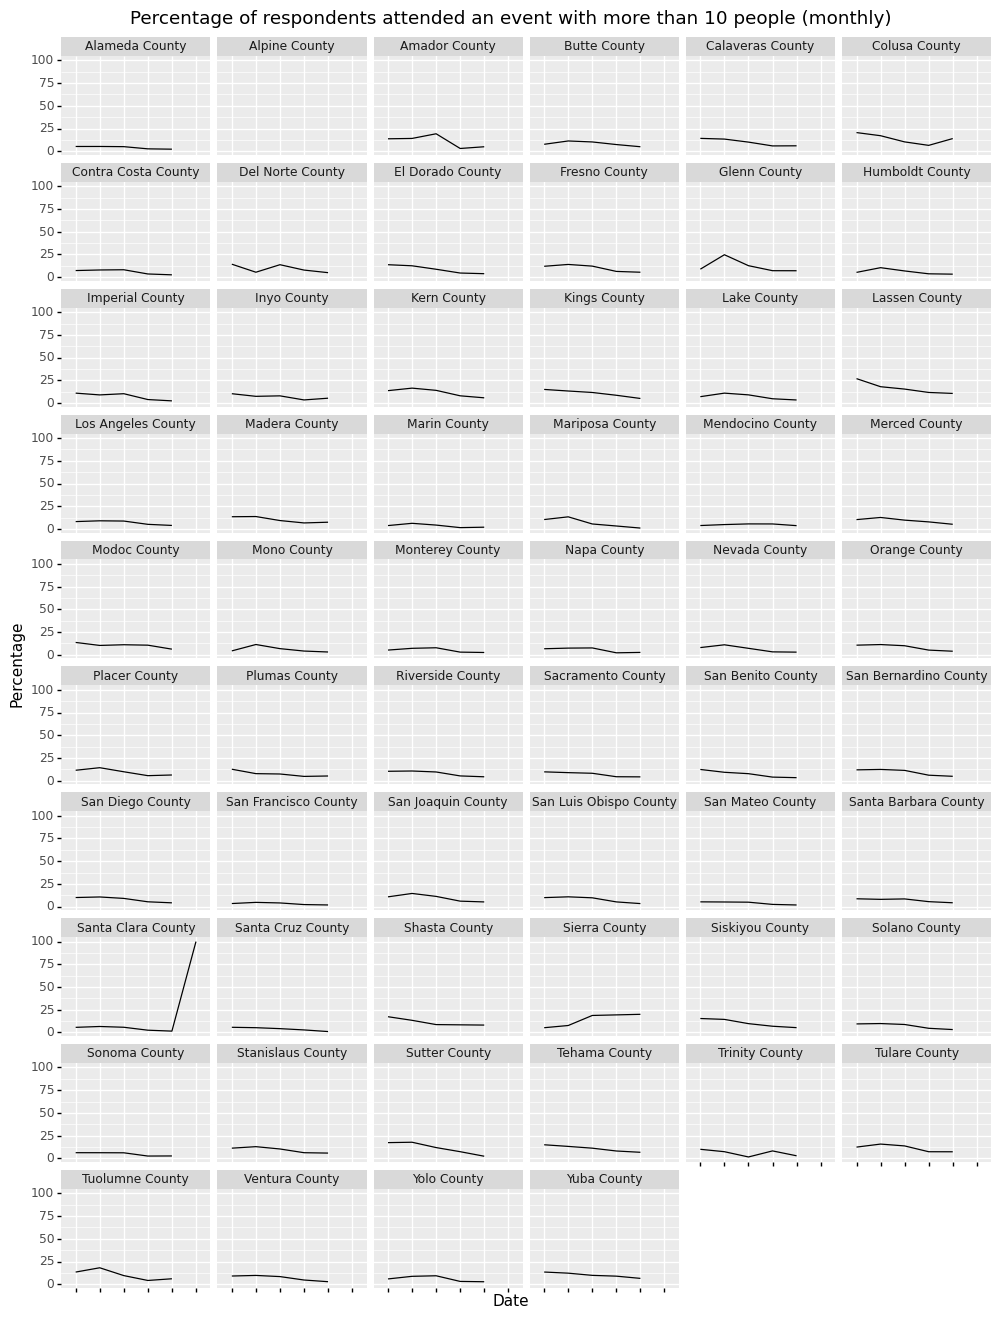

<ggplot: (8757415987902)>

In [17]:
c13_response_5 = c13_response[c13_response["C13"]=="5"]
# merget two dataframe
merged_c13_df_5 = pd.merge(c13_response_5, c13_monthly_total_response, on = ["Date by month", "county"])
merged_c13_df_5["Percentage"]= merged_c13_df_5["count"]/merged_c13_df_5["total_response_for_C13"] * 100
# Aggregate the number of total response by county and date
(
    p9.ggplot(merged_c13_df_5[["Date by month", "county", "Percentage"]], p9.aes(x='Date by month', y='Percentage', group = 1))
    + p9.geom_line() # line plot
    + p9.labs(x='Date', y='Percentage', title="Percentage of respondents attended an event with more than 10 people (monthly)")
    + p9.theme(figure_size=(12, 16), axis_text_x=p9.element_blank())
    + p9.facet_wrap('county', nrow=10)
)

### C13: Used public transit 

/usr/local/lib/python3.6/site-packages/plotnine/geoms/geom_path.py:83: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?


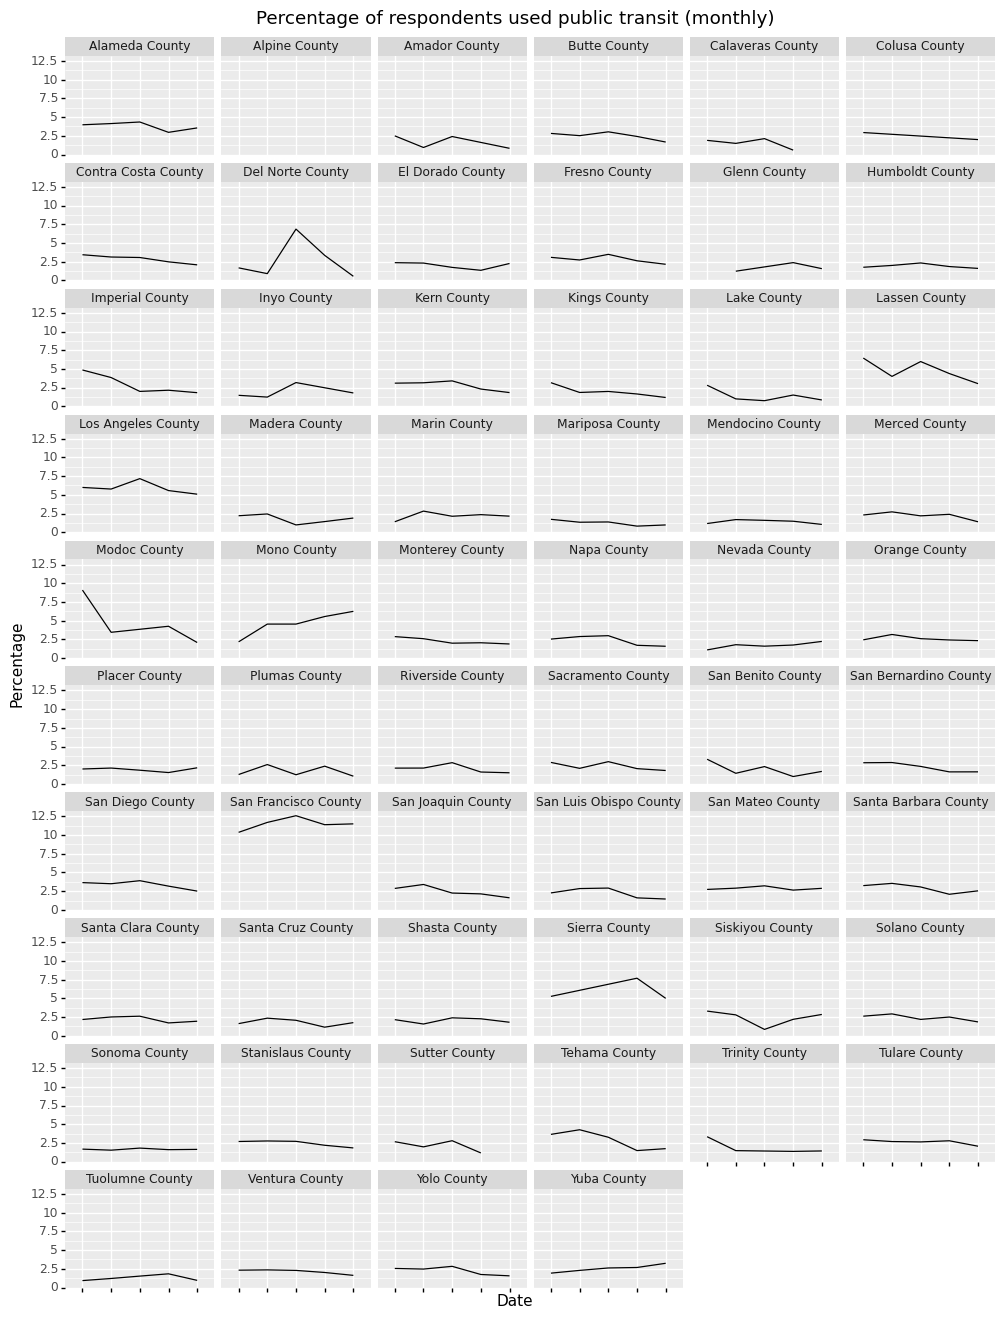

<ggplot: (-9223363279419498836)>

In [18]:
c13_response_6 = c13_response[c13_response["C13"]=="6"]
# merget two dataframe
merged_c13_df_6 = pd.merge(c13_response_6, c13_monthly_total_response, on = ["Date by month", "county"])
merged_c13_df_6["Percentage"]= merged_c13_df_6["count"]/merged_c13_df_6["total_response_for_C13"] * 100
# Aggregate the number of total response by county and date
(
    p9.ggplot(merged_c13_df_6[["Date by month", "county", "Percentage"]], p9.aes(x='Date by month', y='Percentage', group = 1))
    + p9.geom_line() # line plot
    + p9.labs(x='Date', y='Percentage', title="Percentage of respondents used public transit (monthly)")
    + p9.theme(figure_size=(12, 16), axis_text_x=p9.element_blank())
    + p9.facet_wrap('county', nrow=10)
)